# MP2 二阶梯度：微分 Z-Vector 方程

这份文档将会从 MP2 一阶梯度公式出发，推导二阶梯度的表达式并程序化．这是 Cammi, R. et al TCA 2004, 111, 66-77 (doi: 10.1007/s00214-003-0521-8) 提供的非常好的思路，我也打算沿着他们的推导思路来程序化；但这篇文章的公式有许多潜在错误，并且一些表达式不太符合我们的记号习惯．因此，我们将会重新推导公式．

In [1]:
import numpy as np
from pyscf import scf, gto, lib, grad, hessian, dft, mp
import pyscf.hessian.rks
import pyscf.grad.rks
from functools import partial
import pickle
import matplotlib.pyplot as plt

from utilities import val_from_fchk, NumericDiff
from hessian import HFHelper, GGAHelper

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.einsum_path = partial(np.einsum_path, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.set_printoptions(6, linewidth=150, suppress=True)

In [2]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.5  0.0  0.0
H  0.0  0.7  1.5
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

nmo = nao = mol.nao
natm = mol.natm
nocc = mol.nelec[0]
nvir = nmo - nocc
so = slice(0, nocc)
sv = slice(nocc, nmo)
sa = slice(0, nmo)

### 简单的 MP2 梯度类

In [3]:
class MP2Helper:
    
    def __init__(self, mol_):

        nmo = nao = mol_.nao
        natm = mol_.natm
        nocc = mol_.nelec[0]
        nvir = nmo - nocc
        so = slice(0, nocc)
        sv = slice(nocc, nmo)
        sa = slice(0, nmo)
        
        scfh = HFHelper(mol_)
        
        e, eo, ev = scfh.e, scfh.eo, scfh.ev
        C, Co, Cv = scfh.C, scfh.Co, scfh.Cv
        eri0_mo = scfh.eri0_mo

        F_1_mo = scfh.F_1_mo
        S_1_mo = scfh.S_1_mo
        U_1_vo = scfh.U_1_vo
        Ax0_Core = scfh.Ax0_Core
        
        g_mo = eri0_mo
        G_mo = 2 * g_mo - g_mo.swapaxes(-1, -3)
        g_iajb = g_mo[so, sv, so, sv]
        G_iajb = G_mo[so, sv, so, sv]
        
        # Define t, g
        D_iajb = lib.direct_sum("i - a + j - b", eo, ev, eo, ev)
        t_iajb = g_iajb / D_iajb
        T_iajb = 2 * t_iajb - t_iajb.swapaxes(-1, -3)
        
        D_r = np.zeros((nmo, nmo))
        D_r[so, so] += - 2 * np.einsum("iakb, jakb -> ij", T_iajb, t_iajb)
        D_r[sv, sv] += 2 * np.einsum("iajc, ibjc -> ab", T_iajb, t_iajb)

        L = np.zeros((nvir, nocc))
        L1 = np.zeros((nvir, nocc))
        L2 = np.zeros((nvir, nocc))
        L1 += Ax0_Core(sv, so, sa, sa)(D_r)
        L2 -= 4 * np.einsum("jakb, ijbk -> ai", T_iajb, g_mo[so, so, sv, so])
        L2 += 4 * np.einsum("ibjc, abjc -> ai", T_iajb, g_mo[sv, sv, so, sv])
        L = L1 + L2

        D_r[sv, so] = scf.cphf.solve(Ax0_Core(sv, so, sv, so), e, scfh.mo_occ, L, max_cycle=100, tol=1e-13)[0]
        
        # W[I] - Correct with s1-im1 term in PySCF
        D_WI = np.zeros((nmo, nmo))
        D_WI[so, so] = - 2 * np.einsum("iakb, jakb -> ij", T_iajb, g_mo[so, sv, so, sv])
        D_WI[sv, sv] = - 2 * np.einsum("iajc, ibjc -> ab", T_iajb, g_mo[so, sv, so, sv])
        D_WI[sv, so] = - 4 * np.einsum("jakb, ijbk -> ai", T_iajb, g_mo[so, so, sv, so])

        # W[II] - Correct with s1-zeta term in PySCF
        # Note that zeta in PySCF includes HF energy weighted density rdm1e
        # The need of scaler 1 in D_WII[sv, so] is that Aikens use doubled P
        D_WII = np.zeros((nmo, nmo))
        D_WII[so, so] = - 0.5 * D_r[so, so] * lib.direct_sum("i + j -> ij", eo, eo)
        D_WII[sv, sv] = - 0.5 * D_r[sv, sv] * lib.direct_sum("a + b -> ab", ev, ev)
        D_WII[sv, so] = - D_r[sv, so] * eo

        # W[III] - Correct with s1-vhf_s1occ term in PySCF
        D_WIII = np.zeros((nmo, nmo))
        D_WIII[so, so] = - 0.5 * Ax0_Core(so, so, sa, sa)(D_r)

        # Summation
        D_W = D_WI + D_WII + D_WIII
        
        self.D_r = D_r
        self.L = L
        self.L1 = L1
        self.L2 = L2
        self.D_WI = D_WI
        self.D_WII = D_WII
        self.D_WIII = D_WIII
        self.D_W = D_W
        
        return

### 文档定义所用变量

In [4]:
# We use U_1 in this document, but no U_2
# We still using MO basis ERI
# Pre-generate some code here will make later work quicker
# But these operations are numerical-unstable or memory consuming
hfh = HFHelper(mol)
hfh.U_1
hfh.eri0_mo
hfh.eri1_mo
hfh.eri2_mo
hfh

/share/home/zyzhu/Git-Repo/Python-xDH/pyxdh/hessian/hf_helper.py:366: UserWarning: U_1: Generating total U matrix should be considered as numerical unstable!
  warnings.warn("U_1: Generating total U matrix should be considered as numerical unstable!")
/share/home/zyzhu/Git-Repo/Python-xDH/pyxdh/hessian/hf_helper.py:229: UserWarning: eri0_mo: ERI AO -> MO is quite expensive!
  warnings.warn("eri0_mo: ERI AO -> MO is quite expensive!")
/share/home/zyzhu/Git-Repo/Python-xDH/pyxdh/hessian/hf_helper.py:222: UserWarning: eri0_ao: ERI should not be stored in memory! Consider J/K engines!
  warnings.warn("eri0_ao: ERI should not be stored in memory! Consider J/K engines!")
/share/home/zyzhu/Git-Repo/Python-xDH/pyxdh/hessian/hf_helper.py:279: UserWarning: eri1_mo: 4-idx tensor ERI should be not used!
  warnings.warn("eri1_mo: 4-idx tensor ERI should be not used!")
/share/home/zyzhu/Git-Repo/Python-xDH/pyxdh/hessian/hf_helper.py:272: UserWarning: eri1_ao: 4-idx tensor ERI should be not used!
  w

In [5]:
e, eo, ev = hfh.e, hfh.eo, hfh.ev
C, Co, Cv = hfh.C, hfh.Co, hfh.Cv
D = hfh.D
eri0_mo = hfh.eri0_mo
eri1_mo = hfh.eri1_mo
eri2_mo = hfh.eri2_mo

F_1_mo = hfh.F_1_mo
S_1_mo = hfh.S_1_mo
U_1_vo = hfh.U_1_vo
U_1 = hfh.U_1  # Only for verify
B_1 = hfh.B_1
Ax0_Core = hfh.Ax0_Core

MP2 Hessian 参考值如下：

In [6]:
g_array = val_from_fchk("Cartesian Force Constants", "include/mp2_hess/mp2_hess.fchk")
d_hess = natm * 3
hess_mp2_gaussian = np.zeros((d_hess, d_hess))
p = 0
for d1 in range(d_hess):
    for d2 in range(d1 + 1):
        hess_mp2_gaussian[d1][d2] = hess_mp2_gaussian[d2][d1] = g_array[p]
        p += 1
hess_mp2_gaussian = hess_mp2_gaussian.reshape((natm, 3, natm, 3)).swapaxes(1, 2)
hess_mp2_ref = hess_mp2_gaussian - hfh.scf_hess.kernel()

## MP2 一阶梯度：回顾与变量定义

MP2 PySCF 类

In [7]:
hfh.scf_grad.kernel()
mp2_eng = mp.MP2(hfh.scf_eng)
mp2_eng.kernel()[0]
mp2_grad = grad.mp2.Gradients(mp2_eng)
mp2_grad.kernel()

array([[-0.102293,  0.014371,  0.031588],
       [ 0.008573,  0.75439 , -0.009366],
       [ 0.087807,  0.00276 ,  0.014487],
       [ 0.005914, -0.77152 , -0.036708]])

双电子积分

In [8]:
g_mo = eri0_mo
G_mo = 2 * g_mo - g_mo.swapaxes(-1, -3)
g_iajb = g_mo[so, sv, so, sv]
G_iajb = G_mo[so, sv, so, sv]

双电子积分的 Skeleton 梯度

In [9]:
pd_g_mo = eri1_mo
pd_G_mo = 2 * pd_g_mo - pd_g_mo.swapaxes(-1, -3)
pd_g_iajb = pd_g_mo[:, :, so, sv, so, sv]
pd_G_iajb = pd_G_mo[:, :, so, sv, so, sv]

MP2 Amplitude 与能量计算相关表达式

In [10]:
# Define t, g
D_iajb = lib.direct_sum("i - a + j - b", eo, ev, eo, ev)
t_iajb = g_iajb / D_iajb
T_iajb = 2 * t_iajb - t_iajb.swapaxes(-1, -3)
D_mo = lib.direct_sum("i - a + j - b", e, e, e, e)
t_mo = g_mo / D_mo
T_mo = 2 * t_mo - t_mo.swapaxes(-1, -3)

/share/home/zyzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/share/home/zyzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys


验证 MP2 能量

In [11]:
np.allclose((t_iajb * T_iajb * D_iajb).sum(), mp2_eng.e_corr)

True

弛豫密度、加权密度相关量定义

In [12]:
D_r = np.zeros((nmo, nmo))
D_r[so, so] += - 2 * np.einsum("iakb, jakb -> ij", T_iajb, t_iajb)
D_r[sv, sv] += 2 * np.einsum("iajc, ibjc -> ab", T_iajb, t_iajb)

L = np.zeros((nvir, nocc))
L += Ax0_Core(sv, so, sa, sa)(D_r)
L -= 4 * np.einsum("jakb, ijbk -> ai", T_iajb, g_mo[so, so, sv, so])
L += 4 * np.einsum("ibjc, abjc -> ai", T_iajb, g_mo[sv, sv, so, sv])

D_r[sv, so] = scf.cphf.solve(Ax0_Core(sv, so, sv, so), e, hfh.mo_occ, L, max_cycle=100, tol=1e-13)[0]

In [13]:
# W[I] - Correct with s1-im1 term in PySCF
D_WI = np.zeros((nmo, nmo))
D_WI[so, so] = - 2 * np.einsum("iakb, jakb -> ij", T_iajb, g_mo[so, sv, so, sv])
D_WI[sv, sv] = - 2 * np.einsum("iajc, ibjc -> ab", T_iajb, g_mo[so, sv, so, sv])
D_WI[sv, so] = - 4 * np.einsum("jakb, ijbk -> ai", T_iajb, g_mo[so, so, sv, so])

# W[II] - Correct with s1-zeta term in PySCF
# Note that zeta in PySCF includes HF energy weighted density rdm1e
# The need of scaler 1 in D_WII[sv, so] is that Aikens use doubled P
D_WII = np.zeros((nmo, nmo))
D_WII[so, so] = - 0.5 * D_r[so, so] * lib.direct_sum("i + j -> ij", eo, eo)
D_WII[sv, sv] = - 0.5 * D_r[sv, sv] * lib.direct_sum("a + b -> ab", ev, ev)
D_WII[sv, so] = - D_r[sv, so] * eo

# W[III] - Correct with s1-vhf_s1occ term in PySCF
D_WIII = np.zeros((nmo, nmo))
D_WIII[so, so] = - 0.5 * Ax0_Core(so, so, sa, sa)(D_r)

# Summation
D_W = D_WI + D_WII + D_WIII

验证 MP2 一阶梯度，这里采用的一阶梯度公式是

$$
E_\mathrm{elec}^{\mathrm{MP2}, A_t} = D_{pq}^\mathrm{MP2} F_{pq}^{A_t} + W_{pq}^\mathrm{MP2} S_{pq}^{A_t} + 2 T_{ij}^{ab} (\partial_{A_t} g_{ij}^{ab})
$$

In [14]:
np.allclose(
    + (D_r * F_1_mo).sum(axis=(-1, -2))
    + (D_W * S_1_mo).sum(axis=(-1, -2))
    + (2 * T_iajb * pd_g_iajb).sum(axis=(-1, -2, -3, -4)),
    mp2_grad.de - hfh.scf_grad.de
)

True

## MP2 二阶梯度：微分 Z-Vector 方程的不安全实现

In [15]:
e_1 = (B_1 + Ax0_Core(sa, sa, sv, so)(U_1_vo)).diagonal(0, -1, -2)
eo_1, ev_1 = e_1[:, :, so], e_1[:, :, sv]

pdA_D_iajb = (
    + eo_1[:, :, :, None, None, None]
    - ev_1[:, :, None, :, None, None]
    + eo_1[:, :, None, None, :, None]
    - ev_1[:, :, None, None, None, :]
)

Q_1 = B_1 + Ax0_Core(sa, sa, sv, so)(U_1_vo)

In [16]:
pd_g_mo = eri1_mo
pdU_g_mo = (
    + np.einsum("pjkl, Atpi -> Atijkl", g_mo, U_1)
    + np.einsum("ipkl, Atpj -> Atijkl", g_mo, U_1)
    + np.einsum("ijpl, Atpk -> Atijkl", g_mo, U_1)
    + np.einsum("ijkp, Atpl -> Atijkl", g_mo, U_1)
)
pdA_g_mo = pd_g_mo + pdU_g_mo

pdA_G_mo = 2 * pdA_g_mo - pdA_g_mo.swapaxes(-1, -3)

pdA_g_iajb = pdA_g_mo[:, :, so, sv, so, sv]
pdA_G_iajb = pdA_G_mo[:, :, so, sv, so, sv]

pd_pd_g_mo = eri2_mo
pdU_pd_g_mo = (
    # pd on g, U matrix on B
    + np.einsum("Atpjkl, Bspi -> ABtsijkl", pd_g_mo, U_1)
    + np.einsum("Atipkl, Bspj -> ABtsijkl", pd_g_mo, U_1)
    + np.einsum("Atijpl, Bspk -> ABtsijkl", pd_g_mo, U_1)
    + np.einsum("Atijkp, Bspl -> ABtsijkl", pd_g_mo, U_1)
)
pdA_pd_g_mo = pd_pd_g_mo + pdU_pd_g_mo
pdA_pd_g_iajb = pdA_pd_g_mo[:, :, :, :, so, sv, so, sv]

In [17]:
pdA_t_iajb = (
    + pd_g_iajb / D_iajb
    + np.einsum("Atpi, pajb, iajb -> Atiajb", U_1[:, :, :, so], g_mo[:, sv, so, sv], 1 / D_iajb)
    + np.einsum("Atpa, ipjb, iajb -> Atiajb", U_1[:, :, :, sv], g_mo[so, :, so, sv], 1 / D_iajb)
    + np.einsum("Atpj, iapb, iajb -> Atiajb", U_1[:, :, :, so], g_mo[so, sv, :, sv], 1 / D_iajb)
    + np.einsum("Atpb, iajp, iajb -> Atiajb", U_1[:, :, :, sv], g_mo[so, sv, so, :], 1 / D_iajb)
    - np.einsum("Atiajb, iajb, iajb -> Atiajb", pdA_D_iajb, t_iajb, 1 / D_iajb)
)

pdA_T_iajb = 2 * pdA_t_iajb - pdA_t_iajb.swapaxes(-1, -3)

我们可以预先验证 MP2 能量 $E_\mathrm{elec}^\mathrm{MP2} = T_{ij}^{ab} t_{ij}^{ab} D_{ij}^{ab}$ 的一阶梯度在这种表示下是成立的：

$$
E_\mathrm{elec}^{\mathrm{MP2}, A_t} = (\frac{\partial}{\partial A_t} T_{ij}^{ab}) t_{ij}^{ab} D_{ij}^{ab} + T_{ij}^{ab} (\frac{\partial}{\partial A_t} t_{ij}^{ab}) D_{ij}^{ab} + T_{ij}^{ab} t_{ij}^{ab} (\frac{\partial}{\partial A_t} D_{ij}^{ab})
$$

In [18]:
(
    + np.einsum("Atiajb, iajb, iajb -> At", pdA_t_iajb, T_iajb, D_iajb)
    + np.einsum("iajb, Atiajb, iajb -> At", t_iajb, pdA_T_iajb, D_iajb)
    + np.einsum("iajb, iajb, Atiajb -> At", t_iajb, T_iajb, pdA_D_iajb)
) - (mp2_grad.de - hfh.scf_grad.de)

array([[-0., -0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0., -0.],
       [-0., -0., -0.]])

我们也可以验证 MP2 能量 $E_\mathrm{elec}^\mathrm{MP2} = T_{ij}^{ab} g_{ij}^{ab}$ 所表示的一阶梯度：

$$
E_\mathrm{elec}^{\mathrm{MP2}, A_t} = (\frac{\partial}{\partial A_t} T_{ij}^{ab}) g_{ij}^{ab} + T_{ij}^{ab} (\frac{\partial}{\partial A_t} g_{ij}^{ab})
$$

In [19]:
(
    + np.einsum("Atiajb, iajb -> At", pdA_T_iajb, g_iajb)
    + np.einsum("iajb, Atiajb -> At", T_iajb, pdA_g_iajb)
) - (mp2_grad.de - hfh.scf_grad.de)

array([[-0., -0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0., -0.],
       [-0., -0., -0.]])

由此，我们先粗略地列举 MP2 二阶梯度所使用到的项：

\begin{align}
E_\mathrm{elec}^{\mathrm{MP2}, A_t B_s} =
&+ D_{pq}^\mathrm{MP2} (\frac{\partial}{\partial B_s} F_{pq}^{A_t}) + W_{pq}^\mathrm{MP2} (\frac{\partial}{\partial B_s} S_{pq}^{A_t}) \\
&+ (\frac{\partial}{\partial B_s} D_{pq}^\mathrm{MP2}) F_{pq}^{A_t} + (\frac{\partial}{\partial B_s} W_{pq}^\mathrm{MP2}) S_{pq}^{A_t} \\
&+ 2 (\frac{\partial}{\partial B_s} T_{ij}^{ab}) (\partial_{A_t} g_{ij}^{ab}) + 2 T_{ij}^{ab} (\frac{\partial}{\partial B_s} \partial_{A_t} g_{ij}^{ab})
\end{align}

我们简单地称这些项是 MP2 Hessian 的六个贡献项．其中，在现在的推导框架下，第 1, 2, 5, 6 很快可以被求出．

### 第一贡献项 $D_{pq}^\mathrm{MP2} (\frac{\partial}{\partial B_s} F_{pq}^{A_t})$

这一项的难点仅仅在于求取 Fock 一阶 Skeleton 梯度的一阶全导数．我们通过下面的程序验证我们可以生成正确的 `pdA_F_1_mo` $\frac{\partial}{\partial B_s} F_{pq}^{A_t}$：

In [20]:
def mol_to_F_1_mo(mol):
    return HFHelper(mol).F_1_mo
F_1_mo_diff = NumericDiff(mol, mol_to_F_1_mo, deriv=2, symm=False).get_numdif()

In [21]:
pdA_F_1_mo = (
    + hfh.F_2_mo
    + np.einsum("Atpm, Bsmq -> ABtspq", hfh.F_1_mo, U_1)
    + np.einsum("Atmq, Bsmp -> ABtspq", hfh.F_1_mo, U_1)
    + hfh.Ax1_Core(sa, sa, sa, so)(U_1[:, :, :, so])
)

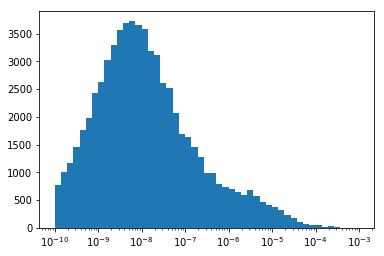

In [22]:
plt.hist(abs(pdA_F_1_mo - F_1_mo_diff).ravel(),
         bins=np.logspace(np.log10(1e-10),np.log10(1e-3), 50))
plt.gca().set_xscale("log")

因此，第一贡献项可以非常直观地写出：

In [23]:
hess_mp2_unsafe_contrib1 = np.einsum("pq, ABtspq -> ABts", D_r, pdA_F_1_mo)

### 第二贡献项 $W_{pq}^\mathrm{MP2} (\frac{\partial}{\partial B_s} S_{pq}^{A_t})$

这一项的难点也仅仅在于求取 `pdA_F_1_mo` $(\frac{\partial}{\partial B_s} S_{pq}^{A_t})$．

In [24]:
def mol_to_S_1_mo(mol):
    return HFHelper(mol).S_1_mo
S_1_mo_diff = NumericDiff(mol, mol_to_S_1_mo, deriv=2, symm=False).get_numdif()

In [25]:
pdA_S_1_mo = (
    + hfh.S_2_mo
    + np.einsum("Atpm, Bsmq -> ABtspq", hfh.S_1_mo, U_1)
    + np.einsum("Atmq, Bsmp -> ABtspq", hfh.S_1_mo, U_1)
)

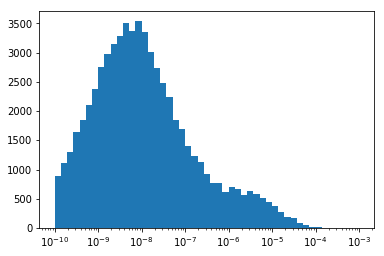

In [26]:
plt.hist(abs(pdA_S_1_mo - S_1_mo_diff).ravel(),
         bins=np.logspace(np.log10(1e-10),np.log10(1e-3), 50))
plt.gca().set_xscale("log")

第二贡献项可以非常直观地写出：

In [27]:
hess_mp2_unsafe_contrib2 = np.einsum("pq, ABtspq -> ABts", D_W, pdA_S_1_mo)

### 第五、六贡献项 $2 (\frac{\partial}{\partial B_s} T_{ij}^{ab}) (\partial_{A_t} g_{ij}^{ab}) + 2 T_{ij}^{ab} (\frac{\partial}{\partial B_s} \partial_{A_t} g_{ij}^{ab})$

第五贡献项所必要的所有分项事实上我们刚才已经求取过了．我们对这些分项简单地加和就得到结果了：

In [28]:
hess_mp2_unsafe_contrib5_6 = (
    + 2 * np.einsum("Bsiajb, Atiajb -> ABts", pdA_T_iajb, pd_g_iajb)
    + 2 * np.einsum("iajb, ABtsiajb -> ABts", T_iajb, pdA_pd_g_iajb)
)

### 重要数值导数结果

In [29]:
#D_r_diff = NumericDiff(mol, lambda mol: MP2Helper(mol).D_r, symm=False).get_numdif()

In [30]:
#L_diff = NumericDiff(mol, lambda mol: MP2Helper(mol).L, symm=False).get_numdif()

In [31]:
#D_WI_diff = NumericDiff(mol, lambda mol: MP2Helper(mol).D_WI, symm=False).get_numdif()
#D_WII_diff = NumericDiff(mol, lambda mol: MP2Helper(mol).D_WII, symm=False).get_numdif()
#D_WIII_diff = NumericDiff(mol, lambda mol: MP2Helper(mol).D_WIII, symm=False).get_numdif()

In [32]:
#L1_diff = NumericDiff(mol, lambda mol: MP2Helper(mol).L1, symm=False).get_numdif()
#L2_diff = NumericDiff(mol, lambda mol: MP2Helper(mol).L2, symm=False).get_numdif()

### 弛豫密度全导数 $\frac{\partial}{\partial A_t} D_{pq}^\mathrm{MP2}$

这是 MP2 梯度推导过程的核心，也是公式理解和程序调试最为困难的部分．

我们先挑软的柿子捏．弛豫密度分为三部分，其中的占据-占据与非占-非占部分的导数较为方便；但非占-占据部分的导数比较复杂．我们的程序中，占据-非占部分始终是零．那么我们先把占据-占据和非占-非占的梯度求取出来：

In [33]:
pdA_D_r = np.zeros((natm, 3, nmo, nmo))
pdA_D_r[:, :, so, so] -= 2 * np.einsum("iakb, Atjakb -> Atij", T_iajb, pdA_t_iajb)
pdA_D_r[:, :, sv, sv] += 2 * np.einsum("iajc, Atibjc -> Atab", T_iajb, pdA_t_iajb)
pdA_D_r[:, :, so, so] -= 2 * np.einsum("Atiakb, jakb -> Atij", pdA_T_iajb, t_iajb)
pdA_D_r[:, :, sv, sv] += 2 * np.einsum("Atiajc, ibjc -> Atab", pdA_T_iajb, t_iajb)

D_r_oo = D_r[so, so]
D_r_vv = D_r[sv, sv]
D_r_vo = D_r[sv, so]
pdA_D_r_oo = pdA_D_r[:, :, so, so]
pdA_D_r_vv = pdA_D_r[:, :, sv, sv]

随后我们求取 Lagrangian 项的全导数：

In [34]:
pdA_L1 = np.zeros((natm, 3, nvir, nocc))
# OO Part
pdA_L1 += hfh.Ax0_Core(sv, so, so, so)(pdA_D_r_oo)
pdA_L1 += hfh.Ax1_Core(sv, so, so, so)(np.array([[D_r_oo]]))[:, 0, :, 0]
pdA_L1 += np.einsum("Atpa, pi -> Atai", U_1[:, :, :, sv], hfh.Ax0_Core(sa, so, so, so)(D_r_oo))
pdA_L1 += np.einsum("Atpi, ap -> Atai", U_1[:, :, :, so], hfh.Ax0_Core(sv, sa, so, so)(D_r_oo))
pdA_L1 += 2 * Ax0_Core(sv, so, sa, so)(np.einsum("Atpk, kl -> Atpl", U_1[:, :, :, so], D_r_oo))
# VV Part
pdA_L1 += hfh.Ax0_Core(sv, so, sv, sv)(pdA_D_r_vv)
pdA_L1 += hfh.Ax1_Core(sv, so, sv, sv)(np.array([[D_r_vv]]))[:, 0, :, 0]
pdA_L1 += np.einsum("Atpa, pi -> Atai", U_1[:, :, :, sv], hfh.Ax0_Core(sa, so, sv, sv)(D_r_vv))
pdA_L1 += np.einsum("Atpi, ap -> Atai", U_1[:, :, :, so], hfh.Ax0_Core(sv, sa, sv, sv)(D_r_vv))
pdA_L1 += 2 * Ax0_Core(sv, so, sa, sv)(np.einsum("Atpb, bc -> Atpc", U_1[:, :, :, sv], D_r_vv))
# pdA_L += hfh.Ax1_Core(sv, so, sv, so)(np.array([[D_r[sv, so]]]))[:, 0, :, 0]
pdA_L2 = np.zeros((natm, 3, nvir, nocc))
pdA_L2 -= 4 * np.einsum("Atjakb, ijbk -> Atai", pdA_T_iajb, g_mo[so, so, sv, so])
pdA_L2 += 4 * np.einsum("Atibjc, abjc -> Atai", pdA_T_iajb, g_mo[sv, sv, so, sv])
pdA_L2 -= 4 * np.einsum("jakb, Atijbk -> Atai", T_iajb, pdA_g_mo[:, :, so, so, sv, so])
pdA_L2 += 4 * np.einsum("ibjc, Atabjc -> Atai", T_iajb, pdA_g_mo[:, :, sv, sv, so, sv])

pdA_L = pdA_L1 + pdA_L2

在求解 CP-HF 方程前，我们还需要做最后一项工作：将原先求取 $D_{ai}^\mathrm{MP2}$ 部分所使用的 CP-HF 方程与 $D_{ai}^\mathrm{MP2}$ 无关的部分的全导数求出．原先的 CP-HF 方程是

$$
(\varepsilon_i - \varepsilon_a) D_{ai}^\mathrm{MP2} - A_{ai, bj} D_{bj}^\mathrm{MP2} = L_{ai}
$$

那么，我们现在的 CP-HF 方程是

$$
(\varepsilon_i - \varepsilon_a) (\frac{\partial}{\partial A_t} D_{ai}^\mathrm{MP2}) - A_{ai, bj} (\frac{\partial}{\partial A_t} D_{bj}^\mathrm{MP2}) = \frac{\partial}{\partial A_t} L_{ai} + (\varepsilon_a^{A_t} - \varepsilon_i^{A_t}) D_{ai}^\mathrm{MP2} + (\frac{\partial}{\partial A_t} A_{ai, bj}) D_{bj}^\mathrm{MP2}
$$

In [35]:
RHS = pdA_L.copy()
RHS += D_r[sv, so] * (ev_1[:, :, :, None] - eo_1[:, :, None, :])
# OV Part
RHS += hfh.Ax1_Core(sv, so, sv, so)(np.array([[D_r[sv, so]]]))[:, 0, :, 0]
RHS += np.einsum("Atpa, pi -> Atai", U_1[:, :, :, sv], hfh.Ax0_Core(sa, so, sv, so)(D_r_vo))
RHS += np.einsum("Atpi, ap -> Atai", U_1[:, :, :, so], hfh.Ax0_Core(sv, sa, sv, so)(D_r_vo))
RHS += Ax0_Core(sv, so, sa, so)(np.einsum("Atpb, bj -> Atpj", U_1[:, :, :, sv], D_r_vo))
RHS += Ax0_Core(sv, so, sa, sv)(np.einsum("Atpj, bj -> Atpb", U_1[:, :, :, so], D_r_vo))

In [36]:
pdA_D_r[:, :, sv, so] = scf.cphf.solve(Ax0_Core(sv, so, sv, so), e, hfh.mo_occ, RHS, max_cycle=100, tol=1e-13)[0].reshape(natm, 3, nvir, nocc)

### 第三贡献项 $(\frac{\partial}{\partial B_s} D_{pq}^\mathrm{MP2}) F_{pq}^{A_t}$

In [37]:
hess_mp2_unsafe_contrib3 = np.einsum("Bspq, Atpq -> ABts", pdA_D_r, F_1_mo)

### 第四贡献项 $(\frac{\partial}{\partial B_s} W_{pq}^\mathrm{MP2}) S_{pq}^{A_t}$

这一个贡献项要求对 $W_{pq}^\mathrm{MP2}$ 进行求导．在有了轨道能导数、分子轨道双电子积分导数的情况下，这是相对来说常规性的工作．我们一项一项来．

In [38]:
pdA_D_WI = np.zeros((natm, 3, nmo, nmo))
pdA_D_WI[:, :, so, so] -= 2 * np.einsum("Atiakb, jakb -> Atij", pdA_T_iajb, g_mo[so, sv, so, sv])
pdA_D_WI[:, :, sv, sv] -= 2 * np.einsum("Atiajc, ibjc -> Atab", pdA_T_iajb, g_mo[so, sv, so, sv])
pdA_D_WI[:, :, sv, so] -= 4 * np.einsum("Atjakb, ijbk -> Atai", pdA_T_iajb, g_mo[so, so, sv, so])
pdA_D_WI[:, :, so, so] -= 2 * np.einsum("iakb, Atjakb -> Atij", T_iajb, pdA_g_mo[:, :, so, sv, so, sv])
pdA_D_WI[:, :, sv, sv] -= 2 * np.einsum("iajc, Atibjc -> Atab", T_iajb, pdA_g_mo[:, :, so, sv, so, sv])
pdA_D_WI[:, :, sv, so] -= 4 * np.einsum("jakb, Atijbk -> Atai", T_iajb, pdA_g_mo[:, :, so, so, sv, so])

In [39]:
pdA_D_WII = np.zeros((natm, 3, nmo, nmo))
pdA_D_WII[:, :, so, so] -= 0.5 * pdA_D_r[:, :, so, so] * (eo[:, None] + eo[None, :])
pdA_D_WII[:, :, sv, sv] -= 0.5 * pdA_D_r[:, :, sv, sv] * (ev[:, None] + ev[None, :])
pdA_D_WII[:, :, sv, so] -= pdA_D_r[:, :, sv, so] * eo
pdA_D_WII[:, :, so, so] -= 0.5 * D_r[so, so] * (eo_1[:, :, :, None] + eo_1[:, :, None, :])
pdA_D_WII[:, :, sv, sv] -= 0.5 * D_r[sv, sv] * (ev_1[:, :, :, None] + ev_1[:, :, None, :])
pdA_D_WII[:, :, sv, so] -= np.einsum("ai, Ati -> Atai", D_r[sv, so], eo_1)

In [40]:
pdA_D_WIII = np.zeros((natm, 3, nmo, nmo))
pdA_D_WIII[:, :, so, so] -= 0.5 * hfh.Ax0_Core(so, so, sa, sa)(pdA_D_r)
pdA_D_WIII[:, :, so, so] -= 0.5 * hfh.Ax1_Core(so, so, sa, sa)(np.array([[D_r]]))[:, 0, :, 0]
pdA_D_WIII[:, :, so, so] -= 0.5 * np.einsum("Atmi, mj -> Atij", U_1[:, :, :, so], hfh.Ax0_Core(sa, so, sa, sa)(D_r))
pdA_D_WIII[:, :, so, so] -= 0.5 * np.einsum("Atmj, im -> Atij", U_1[:, :, :, so], hfh.Ax0_Core(so, sa, sa, sa)(D_r))
pdA_D_WIII[:, :, so, so] -= 0.5 * Ax0_Core(so, so, sa, sa)(np.einsum("Atmp, pq -> Atmq", U_1, D_r))
pdA_D_WIII[:, :, so, so] -= 0.5 * Ax0_Core(so, so, sa, sa)(np.einsum("Atmq, pq -> Atmp", U_1, D_r))

In [41]:
pdA_D_W = pdA_D_WI + pdA_D_WII + pdA_D_WIII

In [42]:
hess_mp2_unsafe_contrib4 = np.einsum("Bspq, Atpq -> ABts", pdA_D_W, S_1_mo)

### 贡献总和

In [43]:
hess_mp2_unsafe = (
    + hess_mp2_unsafe_contrib1
    + hess_mp2_unsafe_contrib2
    + hess_mp2_unsafe_contrib3
    + hess_mp2_unsafe_contrib4
    + hess_mp2_unsafe_contrib5_6
)

In [44]:
np.allclose(hess_mp2_unsafe, hess_mp2_unsafe.swapaxes(0, 1).swapaxes(2, 3))

True

In [45]:
print((hess_mp2_unsafe - hess_mp2_ref).max())
print((hess_mp2_unsafe - hess_mp2_ref).min())

5.801908664962441e-08
-6.048356804289057e-08


## MP2 一阶梯度：安全实现的另一种表述

上面一部分是 MP2 实际实现所用到的代码，是安全的实现；但下面为了方便 MP2 二阶梯度推导，我们将会用另一种方式导出 MP2 的一阶梯度．这种方式需要预先生成一阶 U 矩阵的非占-占据部分，并由此得到 Q 矩阵：

In [46]:
e_1 = (B_1 + Ax0_Core(sa, sa, sv, so)(U_1_vo)).diagonal(0, -1, -2)
eo_1, ev_1 = e_1[:, :, so], e_1[:, :, sv]

pdA_D_iajb = (
    + eo_1[:, :, :, None, None, None]
    - ev_1[:, :, None, :, None, None]
    + eo_1[:, :, None, None, :, None]
    - ev_1[:, :, None, None, None, :]
)

In [47]:
Q_1 = B_1 + Ax0_Core(sa, sa, sv, so)(U_1_vo)

In [48]:
pdF_t_iajb = (
    # Safe
    + pd_g_iajb / D_iajb
    + 2 * np.einsum("Atpi, pajb, iajb -> Atiajb", U_1[:, :, sv, so], g_mo[sv, sv, so, sv], 1 / D_iajb)
    + 2 * np.einsum("Atpa, ipjb, iajb -> Atiajb", U_1[:, :, so, sv], g_mo[so, so, so, sv], 1 / D_iajb)
    - np.einsum("Atiajb, iajb, iajb -> Atiajb", pdA_D_iajb, t_iajb, 1 / D_iajb)
    
    - np.einsum("Atki, kajb, iajb -> Atiajb", S_1_mo[:, :, so, so], g_mo[so, sv, so, sv], 1 / D_iajb)
    
    - np.einsum("Atki, kajb, iajb -> Atiajb", Q_1[:, :, so, so], t_iajb, 1 / D_iajb)
    + np.einsum("Ati, iajb, iajb -> Atiajb", eo_1, t_iajb, 1 / D_iajb)
    
    - np.einsum("Atca, icjb, iajb -> Atiajb", S_1_mo[:, :, sv, sv], g_mo[so, sv, so, sv], 1 / D_iajb)
    
    + np.einsum("Atca, icjb, iajb -> Atiajb", Q_1[:, :, sv, sv], t_iajb, 1 / D_iajb)
    - np.einsum("Ata, iajb, iajb -> Atiajb", ev_1, t_iajb, 1 / D_iajb)
)

pdF_T_iajb = 2 * pdF_t_iajb - pdF_t_iajb.swapaxes(-1, -3)

In [49]:
(
    + np.einsum("Atiajb, iajb, iajb -> At", pdF_t_iajb, T_iajb, D_iajb)
    + np.einsum("iajb, Atiajb, iajb -> At", t_iajb, pdF_T_iajb, D_iajb)
    + np.einsum("iajb, iajb, Atiajb -> At", t_iajb, T_iajb, pdA_D_iajb)
) - (mp2_grad.de - hfh.scf_grad.de)

array([[-0., -0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0., -0.],
       [-0., -0., -0.]])

In [50]:
(pdF_t_iajb - pdA_t_iajb).max()

0.13207778240251927

In [51]:
np.allclose(
    np.einsum("Atiajb, iajb, iajb -> At", pdA_t_iajb, T_iajb, D_iajb),
    np.einsum("Atiajb, iajb, iajb -> At", pdF_t_iajb, T_iajb, D_iajb)
)

True